In [1]:
from openpyxl import Workbook
from openpyxl import load_workbook
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import statsmodels.api as sm
from sklearn import metrics
from random import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD

Using TensorFlow backend.


M
Lowest Error In Validation _MSE_  108.06605657825443
Best Learning Rate is:  0.01
Best Batch Size is:  128
Best Dropout Rate is:  0.0
65/65 [==============================] - 1s 9ms/step
H
Lowest Error In Validation _MSE_  137.42465879967457
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.0
12/12 [==============================] - 1s 104ms/step
I
Lowest Error In Validation _MSE_  162.9884672605947
Best Learning Rate is:  0.005
Best Batch Size is:  128
Best Dropout Rate is:  0.0
21/21 [==============================] - 2s 91ms/step
N
Lowest Error In Validation _MSE_  154.0237919376832
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.0
85/85 [==============================] - 3s 32ms/step
K
Lowest Error In Validation _MSE_  124.3131000473061
Best Learning Rate is:  0.02
Best Batch Size is:  128
Best Dropout Rate is:  0.1
24/24 [==============================] - 4s 152ms/step
G
Lowest Error In Validation _MSE_  146.03464638077

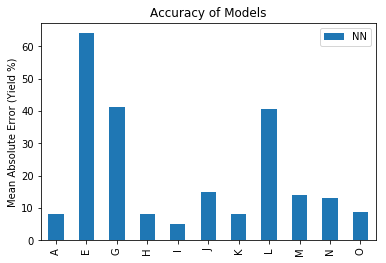

In [2]:
data = pd.read_csv("data.csv")
data = data.sample(frac=1).reset_index(drop=True)
pd.options.mode.chained_assignment = None


XLabels = ['TotalT','Temp','LSR','CA','Size', 'Moisture', 'IsoT', 'HeatT', 'Ramp','F_X', 'Ro', 'logRo', 'P']
X = data[XLabels]
#Scaling X
sc = StandardScaler()
X = sc.fit_transform(X)
data[XLabels] = X

papers = data['ID'].unique()
shuffle(papers)

#Remvoing papers from test list if they have less  than 10 points
papersWithLessThanXPoints = []
for paper in papers:
    dataFromPaper = data[data['ID'] == paper]
    if len(dataFromPaper.index) < 10:
        papersWithLessThanXPoints.append(paper)
papers = [x for x in papers if x not in papersWithLessThanXPoints]

numPapers = len(papers)
papersPerGroup = 2
numBins = 10

error_Frame = pd.DataFrame(columns=['ID', 'NN'])
          
numEpoch = 3000

for paper in papers:
    print(paper)
    train_Frame = data[data['ID'] != paper]
    test_Frame = data[data['ID'] == paper]
    
    papers = train_Frame['ID'].unique()
    
    
    numPapers = len(papers)
    #combos = [papers[x:x + papersPerGroup] for x in range(0, len(papers), papersPerGroup)]  
    combos = []
    for x in range(0, len(papers), papersPerGroup):
        if x + papersPerGroup < len(papers):
            combos.append(papers[x:x + papersPerGroup])
        else:
            combos.append(papers[x:])

    lenTrain = len(train_Frame.index)
    train_Frame, valid_Frame, train_valid_Frame = train_Frame.iloc[:int(lenTrain * 0.8), :], train_Frame.iloc[int(lenTrain * 0.8):, :], train_Frame

    #Calculating Sample Weight
    bins = train_Frame['Yield'].value_counts(bins=numBins)
    for i in train_Frame.index:
        for j in bins.index:
            if int(train_Frame.at[i, 'Yield']) in j:
                train_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()

            
    bins = train_valid_Frame['Yield'].value_counts(bins=numBins)
    for i in train_valid_Frame.index:
        for j in bins.index:
            if int(train_valid_Frame.at[i, 'Yield']) in j:
                train_valid_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()
    
    y_train, y_valid, y_test, y_train_valid = train_Frame['Yield'], valid_Frame['Yield'], test_Frame['Yield'], train_valid_Frame['Yield']
    X_train, X_valid, X_test, X_train_valid = train_Frame[XLabels], valid_Frame[XLabels], test_Frame[XLabels], train_valid_Frame[XLabels]

    train_weights = train_Frame['Sample_Weight']
    train_valid_weights = train_valid_Frame['Sample_Weight']
    

    ##NN
    learningRates = [0.002, 0.005, 0.01, 0.02]
    batchSizes = [128]
    dropoutRates = [0.00, 0.1]
    errors = []
    for lr_ in learningRates:
        for bs in batchSizes:
            for dr in dropoutRates:
                sumErrors = 0
                for c in combos:
                    train_Frame = train_valid_Frame[~train_valid_Frame['ID'].isin(c)]
                    valid_Frame = train_valid_Frame[train_valid_Frame['ID'].isin(c)]

                    ##Calculating Sample Weight again just for train frame, because it's different
                    bins = train_Frame['Yield'].value_counts(bins=numBins)
                    for i in train_Frame.index:
                        for j in bins.index:
                            if int(train_Frame.at[i, 'Yield']) in j:
                                train_Frame.at[i, 'Sample_Weight'] = 100/bins[j].item()

                    y_train, y_valid, y_test, y_train_valid = train_Frame['Yield'], valid_Frame['Yield'], test_Frame['Yield'], train_valid_Frame['Yield']
                    X_train, X_valid, X_test, X_train_valid = train_Frame[XLabels], valid_Frame[XLabels], test_Frame[XLabels], train_valid_Frame[XLabels]

                    train_weights = train_Frame['Sample_Weight']
                    
                    model = Sequential()
                    model.add(Dense(units=12, activation='sigmoid', input_dim=13))
                    model.add(Dropout(dr))
                    model.add(Dense(units=12, activation='sigmoid'))
                    model.add(Dense(units=6, activation='sigmoid'))
                    model.add(Dense(units=6, activation='sigmoid'))
                    model.add(Dense(units=1, activation='softplus'))

                    sgd = SGD(lr=lr_)  
                    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

                
                    model.fit(X_train, y_train, sample_weight=np.asarray(train_weights), epochs=numEpoch, batch_size=bs ,verbose=0)

#                     loss_and_metrics = model.evaluate(X_valid, y_valid,batch_size=bs)
                    
#                     print(X_valid)
                    y_pred = model.predict(X_valid, batch_size=bs)
                    y_pred = y_pred.flatten()
                    error =  metrics.mean_absolute_error(y_valid, y_pred)
                    sumErrors = sumErrors + error
                errors.append(sumErrors)
    index_of_lowest_error = np.argmin(errors)
          
    print("Lowest Error In Validation _MSE_ ", np.min(errors))

    best_lr = learningRates[int(index_of_lowest_error / (len(batchSizes) * len(dropoutRates)))] #Good
    best_bs = batchSizes[int((index_of_lowest_error % (len(batchSizes) * len(dropoutRates)))/len(dropoutRates))] #Good
    best_dr = dropoutRates[index_of_lowest_error % len(dropoutRates)] #Good 
    print("Best Learning Rate is: ",best_lr)
    print("Best Batch Size is: ", best_bs)
    print("Best Dropout Rate is: ", best_dr)    


    #Using best values

    model = Sequential()
    model.add(Dense(units=12, activation='sigmoid', input_dim=13))
    model.add(Dropout(best_dr))
    model.add(Dense(units=12, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=6, activation='sigmoid'))
    model.add(Dense(units=1, activation='softplus'))

    sgd = SGD(lr=best_lr)  
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

    model.fit(X_train_valid, y_train_valid, sample_weight=np.asarray(train_valid_weights), epochs=numEpoch, batch_size=best_bs ,verbose=0)

    loss_and_metrics = model.evaluate(X_test, y_test,batch_size=best_bs)

    y_pred = model.predict(X_test, batch_size=bs)
    y_pred = y_pred.flatten()
          
    mseNN = metrics.mean_absolute_error(y_test, y_pred)
  

    row = [[paper, mseNN]]
    tempDf = pd.DataFrame(row, columns=['ID', 'NN'])
    error_Frame = pd.concat([error_Frame, tempDf], ignore_index=True)
    error_Frame.index = error_Frame['ID'].values
    error_Frame = error_Frame.sort_index()
    error_Frame.to_csv("CrossValidNN.csv")

    
error_Frame.reset_index()
error_Frame.index = error_Frame['ID'].values
error_Frame = error_Frame.sort_index()


error_Frame.plot(kind='bar', stacked=False)
error_Frame.to_csv("CrossValidNN.csv")

plt.ylabel('Mean Absolute Error (Yield %)')
plt.title("Accuracy of Models")
plt.savefig("CrossValidNN.png", dpi=600, bbox_inches='tight')

